vgg pretrained (fine tuned)

In [2]:
import tensorflow as tf
from keras.layers import Conv3D, Dense, MaxPooling3D, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.applications.vgg16 import VGG16

from keras.applications.vgg16 import preprocess_input

import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics as mt

import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from matplotlib import pyplot as plt

import csv

In [3]:
pd.options.display.max_rows = 10

In [4]:
# adam optimizer default learning rate = 0.001
lr = 0.0001 #learning rate
ep = 1
batch_size = 1
n_splits = 5

In [5]:
# not performing fine tuning during training
def get_model(num_classes):

    #returns compiled model for the smri pipeline
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add classification layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = True

    model.compile(optimizer=Adam(learning_rate = lr), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Output shape of the model:", model.output_shape)

    return model

In [6]:
def compile_fit(model, X_train, y_train, X_val, y_val):

    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ep, batch_size = batch_size)

    return model, hist

In [7]:
def plot_history(hist, n):
    fig, ax = plt.subplots(2)
    ax[0].plot(hist.history['accuracy'], color="blue")
    ax[0].plot(hist.history['val_accuracy'], color="green")
    ax[0].set(xlabel="epochs", ylabel="Accuracy")
    ax[0].set_xlim((0,ep))
    ax[0].set_ylim((0,1))
    ax[0].legend(['training', 'testing'])
    ax[0].set_title("Accuracy Trend")

    ax[1].plot(hist.history['loss'], color="blue")
    ax[1].plot(hist.history['val_loss'], color="green")
    ax[1].set(xlabel="epochs", ylabel="Loss")
    ax[1].set_xlim((0,ep))
    ax[1].set_ylim((0,1))
    ax[1].legend(['training', 'testing'])
    ax[1].set_title("Loss Trend")

    fig.tight_layout(pad=2.0)
    plt.show()

In [8]:
def eval_model(num_classes, model, X_val, y_val, y_cols):
  # Compute loss and accuracy using model.evaluate()
  loss, acc = model.evaluate(X_val, y_val)

  y_pred = model.predict(X_val)
  print('y_pred', y_pred)
  print('y_val', y_val)

  if (num_classes == 3) :

    # Convert y_val to multiclass format
    y_val = np.argmax(y_val, axis=1)

    # Convert y_pred to multiclass format
    y_pred = np.argmax(y_pred, axis=1)

    print('y_pred', y_pred)
    print('y_val', y_val)

    # Check the type of y_pred_probs
    print("Type of y_pred using model.predict:", type(y_pred))
    print("shape of the y_pred using model.predict:", y_pred.shape)

    # Compute confusion matrix
    # y_val_argmax = np.argmax(y_val, axis=1)
    # y_pred_argmax = np.argmax(y_pred, axis=1)
    # conf_mat = confusion_matrix(y_val_argmax, y_pred_argmax)

    conf_mat = mt.confusion_matrix(y_val, y_pred)
    print("confusion matrix ", conf_mat)

    target_names = y_cols

    print("classification report", mt.classification_report(y_val, y_pred, target_names=target_names, digits = 3))

    # Compute classification report
    report = mt.classification_report(y_val, y_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).T

    print("classification report in dataframe - match accuracy with model.evaluate ")
    print(report_df)

    # Select the first three rows
    report_df_top3 = report_df.head(3)

    # Calculate average metrics for the first three rows
    avg_precision = report_df_top3['precision'].mean()
    avg_recall = report_df_top3['recall'].mean()
    avg_f1_score = report_df_top3['f1-score'].mean()

    print(f"Average Precision (first 3 classes): {avg_precision:.3f}")
    print(f"Average Recall (first 3 classes): {avg_recall:.3f}")
    print(f"Average F1-Score (first 3 classes): {avg_f1_score:.3f}")

    metrics = {
        'acc': acc,
        'loss': loss,
        'conf_mat': conf_mat,
        'sens (recall)': avg_recall,
        'f1': avg_f1_score,
        'prec': avg_precision
    }

  elif (num_classes == 2) :

    # Convert y_val to multiclass format
    y_val = np.argmax(y_val, axis=1)

    # Convert y_pred to multiclass format
    y_pred = np.argmax(y_pred, axis=1)

    print('y_pred', y_pred)
    print('y_val', y_val)

    # Check the type of y_pred_probs
    print("Type of y_pred using model.predict:", type(y_pred))
    print("shape of the y_pred using model.predict:", y_pred.shape)

    # Compute confusion matrix
    conf_mat = confusion_matrix(y_val, y_pred)

    # Compute confusion matrix
    # y_pred = np.argmax(y_pred, axis=1)
    # conf_mat = confusion_matrix(y_val, y_pred)

    # Compute metrics from confusion matrix
    tn, fp, fn, tp = conf_mat.ravel()
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    metrics = {
        'acc': acc,
        'loss': loss,
        'conf_mat': conf_mat,
        'sens (recall)': recall,
        'f1': f1,
        'prec': precision,
        'tn': tn,
        'tp': tp,
        'fn': fn,
        'fp': fp
    }

  else :
    metrics = {}

  return metrics

In [9]:
# Replacing nan values to 1
def nan_to_0(data):

    df1 = data.copy()

    for idx, row in df1.iterrows():
      arr = row['psi_matrix']
      matrix = np.nan_to_num(arr, copy = True, nan = 0.0)
      df1.at[idx, 'psi_matrix'] = matrix

    print(df1)

    return df1

In [10]:
def computeMinMax(X):
  min_matrix = X.min(axis = 0)
  max_matrix = X.max(axis = 0)
  return (min_matrix, max_matrix)

In [11]:
def normalize_instance(X, minn, maxx):
  normalised_X = np.zeros(shape=(X.shape[0], X.shape[1]))

  for idx, x in np.ndenumerate(X):
    if np.all(minn[idx] == maxx[idx]):
      normalised_X = x
    else:
      normalised_X[idx] = (x - minn[idx])/(maxx[idx] - minn[idx])
    return normalised_X

In [12]:
def normalize(X_train, X_val):
    # Assuming X_train is your DataFrame with matrices in a single column
    matrices = X_train  # Get the values from the 'matrices' column
    # Convert the matrices to a 2D NumPy array
    X_train_2d = np.stack(matrices)

    # Assuming X_train is your DataFrame with matrices in a single column
    matrices = X_val  # Get the values from the 'matrices' column
    # Convert the matrices to a 2D NumPy array
    X_val_2d = np.stack(matrices)

    min_matrix, max_matrix = computeMinMax(X_train_2d)

    print("shape of min matrix", min_matrix.shape)
    print("shape of max matrix", max_matrix.shape)

    normalized_instances = []
    for instance in X_train_2d:
        normalized_instance = normalize_instance(instance, min_matrix, max_matrix)
        normalized_instances.append(normalized_instance)

    # Convert the list of normalized instances to a NumPy array
    X_normalized_trained_2d = np.array(normalized_instances)

    normalized_instances = []
    for instance in X_val_2d:
        normalized_instance = normalize_instance(instance, min_matrix, max_matrix)
        normalized_instances.append(normalized_instance)

    # Convert the list of normalized instances to a NumPy array
    X_normalized_val_2d = np.array(normalized_instances)

    return (X_normalized_trained_2d, X_normalized_val_2d)

In [13]:
# # Padding Matrices
# def padding_data(data):
#     def pad_matrix(row):
#         arr = row['fcmap']
#         pad_top = (224 - arr.shape[0]) // 2
#         pad_bottom = 224 - arr.shape[0] - pad_top
#         pad_left = (224 - arr.shape[1]) // 2
#         pad_right = 224 - arr.shape[1] - pad_left
#         padded_matrix = np.pad(arr, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
#         return padded_matrix

#     df_pad = data.copy()

#     df_pad['fcmap'] = df_pad.apply(lambda row: pad_matrix(row), axis=1)

#     return df_pad

def padding_data(X, target_shape=(224, 224)):
    """
    Pad each matrix in X_train to the target shape.

    Args:
        X_train (numpy.ndarray): Input array containing matrices.
        target_shape (tuple): Target shape for padding.

    Returns:
        numpy.ndarray: Padded matrices.
    """
    padded_matrices = []

    for matrix in X:
        pad_top = (target_shape[0] - matrix.shape[0]) // 2
        pad_bottom = target_shape[0] - matrix.shape[0] - pad_top
        pad_left = (target_shape[1] - matrix.shape[1]) // 2
        pad_right = target_shape[1] - matrix.shape[1] - pad_left

        padded_matrix = np.pad(matrix, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
        padded_matrices.append(padded_matrix)

    return np.array(padded_matrices)

In [14]:
def increase_channels(X):
    # preparing data for vgg pre-trained
    X = np.stack(X).reshape(-1, 224, 224)
    print("stacking all matrices together", X.shape)
    X = np.expand_dims(X, axis=-1)
    print("adding channel dimension", X.shape)
    X = np.repeat(X, 3, axis=-1)
    print("increasing channels for vgg", X.shape)

    return X

In [15]:
def make_dataset(choice):
    # Load dataframe from the pickle file
    data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/ROIxTimeseries/psi_data.pkl')

    if choice == 'A':
        # Filter rows where 'adhd' or 'autism' is 1 (keep only ADHD or autism subjects)
        data = data[(data['adhd'] == 1) | (data['autism'] == 1)]
        y_cols = ['adhd', 'autism']  # Specify the columns for y
    elif choice == 'B':
        # Filter rows where 'autism' or 'healthy' is 1 (keep only autism or healthy subjects)
        data = data[(data['autism'] == 1) | (data['healthy'] == 1)]
        y_cols = ['autism', 'healthy']  # Specify the columns for y
    elif choice == 'C':
        # Filter rows where 'adhd' or 'healthy' is 1 (keep only ADHD or healthy subjects)
        data = data[(data['adhd'] == 1) | (data['healthy'] == 1)]
        y_cols = ['adhd', 'healthy']  # Specify the columns for y
    elif choice == 'D':
        # Keep all rows
        y_cols = ['adhd', 'autism', 'healthy']  # Specify the columns for y
    else:
        print("Invalid choice. Please enter 'A', 'B', 'C', or 'D'.")
        return pd.DataFrame(), []

    print(data)
    print(y_cols)
    return data, y_cols

In [16]:
def driver(choice):

    # choice = input("Enter your choice (A, B, C, or D): ").upper()

    choice = choice.upper()

    df, y_cols = make_dataset(choice)
    #print(d.head)

    X = df['psi_matrix'].values
    # print(X.shape)
    # print(X)
    print("type of matrices", type(X))
    y = df[y_cols].values
    #y = to_categorical(y, num_classes=3)
    # print(y.shape)
    # print(y)
    print("type of label columns", type(y))

    # Get the number of classes
    num_classes = y.shape[1]
    print("No. of classes", num_classes)

    if (num_classes == 2) :
      result_df = pd.DataFrame(columns = ['fold','acc','loss','conf_mat', 'sens (recall)','f1','prec', 'tn', 'tp', 'fn', 'fp'])
    elif (num_classes == 3) :
      result_df = pd.DataFrame(columns = ['fold','acc','loss','conf_mat', 'sens (recall)','f1','prec'])
    else :
      result_df = {}

    # input_shape_2 = X[0].shape
    # # input_shape = input_shape + (2,)
    # print(input_shape_2) // in case, sent as argument to get_model()

    # n_splits = n_splits # Number of folds

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    tf.keras.backend.clear_session()
    for i, (train_index, val_index) in enumerate(kf.split(X, y)):

        print("FOLD : ", i+1)

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # X_normal_train, X_normal_val = normalize(X_train, X_val)

        X_train_pad = padding_data(X_train)
        X_val_pad = padding_data(X_val)

        X_train_vgg = increase_channels(X_train_pad)
        X_val_vgg = increase_channels(X_val_pad)

        # print(X_val_vgg[0].shape)

        compiled_m = get_model(num_classes)

        #compiled_m.summary()
        trained_m, history = compile_fit(compiled_m, X_train_vgg, np.array(y_train), X_val_vgg, np.array(y_val))
        plot_history(history, i+1)

        scores = eval_model(num_classes, trained_m, X_val_vgg, y_val, y_cols)
        scores['fold']=i+1
        print("Scores", scores)
        scores = pd.DataFrame([scores])
        result_df = pd.concat([result_df,scores], ignore_index=True)
        tf.keras.backend.clear_session()

    return result_df

      subject                                         psi_matrix  adhd  \
0    subject1  [[1.0, 0.9121749319470445, 0.5998911447858901,...     0   
1    subject2  [[1.0, 0.737845980508526, 0.6564429476312834, ...     0   
2    subject3  [[1.0, 0.7745085228540051, 0.6128628356660338,...     0   
3    subject4  [[1.0, 0.9101208647908265, 0.5761238195504282,...     0   
4    subject5  [[1.0, 0.8178086643416217, 0.5200617901160923,...     0   
..        ...                                                ...   ...   
55  subject56  [[1.0, 0.8891425744550154, 0.6286926252916647,...     1   
56  subject57  [[1.0, 0.6453100901805766, 0.5973823563942433,...     1   
57  subject58  [[1.0, 0.6703420592249697, 0.5755276208870715,...     1   
58  subject59  [[1.0, 0.8923502283453747, 0.6115053963834316,...     1   
59  subject60  [[1.0, 0.9147961914292171, 0.5331531966259069,...     1   

    autism  healthy  
0        1        0  
1        1        0  
2        1        0  
3        1        0  
4

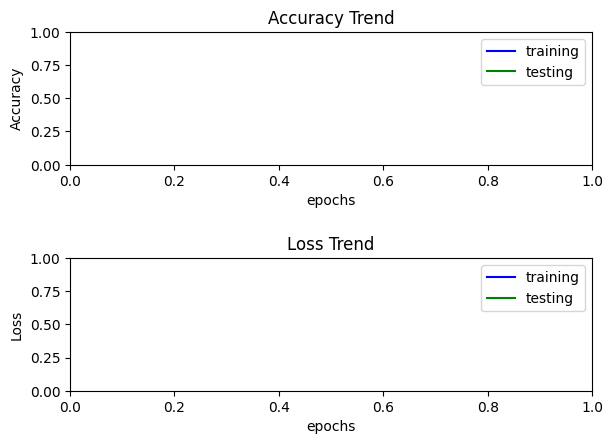

1/1 [==============================] - 0s 167ms/step
y_pred [[0.5102544  0.48974562]
 [0.50905514 0.4909448 ]
 [0.5117378  0.48826218]
 [0.5113948  0.4886052 ]
 [0.51161796 0.48838207]
 [0.5103153  0.48968473]
 [0.5092016  0.49079844]
 [0.51082665 0.4891734 ]
 [0.5113555  0.48864448]
 [0.51334125 0.48665875]
 [0.5102173  0.4897827 ]
 [0.510856   0.48914403]]
y_val [[0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
y_pred [0 0 0 0 0 0 0 0 0 0 0 0]
y_val [1 1 1 1 0 0 0 0 0 0 0 0]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.6666666865348816, 'loss': 0.6858355402946472, 'conf_mat': array([[8, 0],
       [4, 0]]), 'sens (recall)': 0.0, 'f1': 0.0, 'prec': 0.0, 'tn': 8, 'tp': 0, 'fn': 4, 'fp': 0, 'fold': 1}
FOLD :  2
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
stacking all matrices together 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Output shape of the model: (None, 2)
48/48 [==============================] - 6s 49ms/step - loss: 1.0431 - accuracy: 0.4167 - val_loss: 0.6933 - val_accuracy: 0.5000


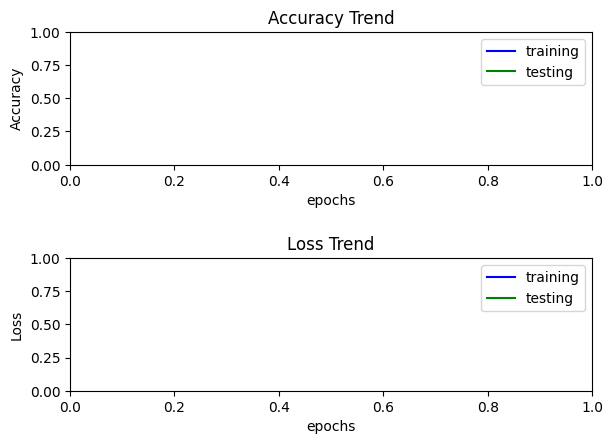

1/1 [==============================] - 0s 143ms/step
y_pred [[0.49163088 0.50836915]
 [0.4916158  0.50838417]
 [0.49161527 0.5083847 ]
 [0.49163917 0.50836086]
 [0.49161205 0.5083879 ]
 [0.49164188 0.5083581 ]
 [0.4916308  0.5083692 ]
 [0.49163485 0.50836515]
 [0.49168453 0.5083155 ]
 [0.49166748 0.50833255]
 [0.49166578 0.5083342 ]
 [0.49167496 0.508325  ]]
y_val [[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
y_pred [1 1 1 1 1 1 1 1 1 1 1 1]
y_val [1 1 1 1 1 1 0 0 0 0 0 0]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.5, 'loss': 0.6932530403137207, 'conf_mat': array([[0, 6],
       [0, 6]]), 'sens (recall)': 1.0, 'f1': 0.6666666666666666, 'prec': 0.5, 'tn': 0, 'tp': 6, 'fn': 0, 'fp': 6, 'fold': 2}
FOLD :  3
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
stacking all matrices together 

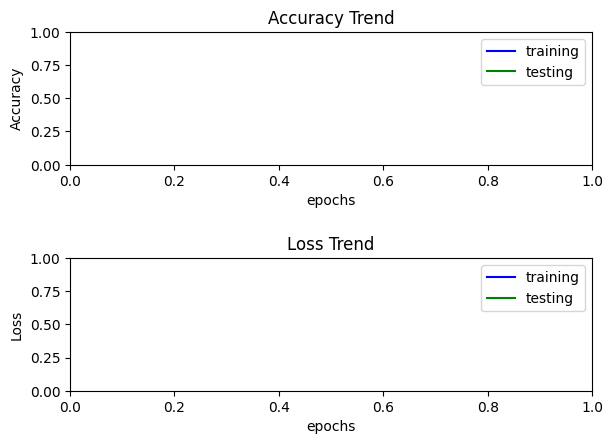

1/1 [==============================] - 0s 138ms/step
y_pred [[0.9166585  0.08334145]
 [0.9173287  0.08267131]
 [0.91730696 0.08269306]
 [0.91753334 0.08246666]
 [0.9205956  0.07940441]
 [0.9200757  0.07992431]
 [0.91984165 0.08015839]
 [0.9200776  0.07992242]
 [0.9165245  0.08347548]
 [0.9176601  0.08233994]
 [0.9162124  0.08378766]
 [0.91679335 0.08320657]]
y_val [[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
y_pred [0 0 0 0 0 0 0 0 0 0 0 0]
y_val [1 1 1 1 1 1 1 1 0 0 0 0]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.3333333432674408, 'loss': 1.7019561529159546, 'conf_mat': array([[4, 0],
       [8, 0]]), 'sens (recall)': 0.0, 'f1': 0.0, 'prec': 0.0, 'tn': 4, 'tp': 0, 'fn': 8, 'fp': 0, 'fold': 3}
FOLD :  4
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
stacking all matrices together 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Output shape of the model: (None, 2)
48/48 [==============================] - 6s 48ms/step - loss: 0.9403 - accuracy: 0.5000 - val_loss: 0.7251 - val_accuracy: 0.4167


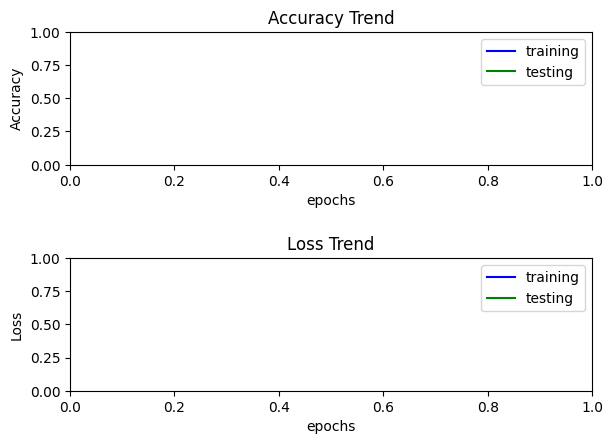

1/1 [==============================] - 0s 209ms/step
y_pred [[0.42697245 0.57302755]
 [0.43012503 0.56987494]
 [0.42387652 0.5761235 ]
 [0.42268056 0.57731944]
 [0.4289371  0.5710629 ]
 [0.42876726 0.5712327 ]
 [0.42546785 0.57453215]
 [0.4312361  0.5687639 ]
 [0.42675278 0.5732472 ]
 [0.43337378 0.56662625]
 [0.42643294 0.57356703]
 [0.4325639  0.5674361 ]]
y_val [[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
y_pred [1 1 1 1 1 1 1 1 1 1 1 1]
y_val [1 1 1 1 1 0 0 0 0 0 0 0]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.4166666567325592, 'loss': 0.7250620722770691, 'conf_mat': array([[0, 7],
       [0, 5]]), 'sens (recall)': 1.0, 'f1': 0.5882352941176471, 'prec': 0.4166666666666667, 'tn': 0, 'tp': 5, 'fn': 0, 'fp': 7, 'fold': 4}
FOLD :  5
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
s

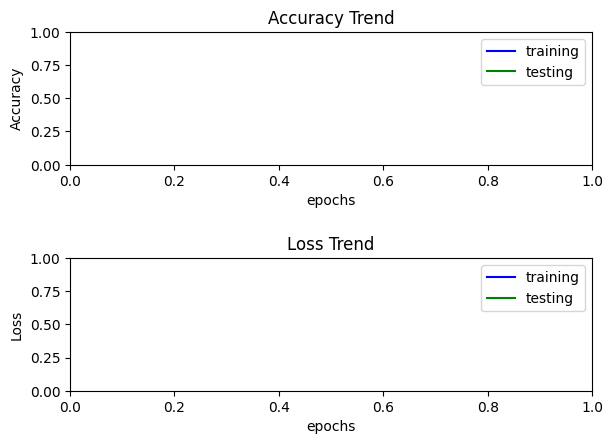

1/1 [==============================] - 0s 251ms/step - loss: 0.8531 - accuracy: 0.4167


1/1 [==============================] - 0s 140ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


y_pred [[0.7209645  0.27903545]
 [0.7154942  0.28450575]
 [0.70200306 0.2979969 ]
 [0.7161141  0.2838859 ]
 [0.6972543  0.30274564]
 [0.7113826  0.28861737]
 [0.7011921  0.2988079 ]
 [0.72299224 0.27700776]
 [0.7329295  0.26707047]
 [0.72914726 0.2708527 ]
 [0.72647184 0.2735282 ]
 [0.7276666  0.27233338]]
y_val [[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
y_pred [0 0 0 0 0 0 0 0 0 0 0 0]
y_val [1 1 1 1 1 1 1 0 0 0 0 0]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.4166666567325592, 'loss': 0.853096067905426, 'conf_mat': array([[5, 0],
       [7, 0]]), 'sens (recall)': 0.0, 'f1': 0.0, 'prec': 0.0, 'tn': 5, 'tp': 0, 'fn': 7, 'fp': 0, 'fold': 5}
      subject                                         psi_matrix  adhd  \
0    subject1  [[1.0, 0.9121749319470445, 0.5998911447858901,...     0   
1    subject2  [[1.0, 0.737845980508526, 0.6564429476312834, ...     0   
2    sub

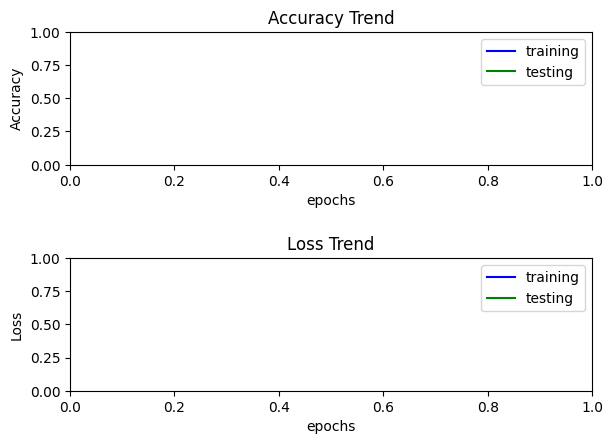

1/1 [==============================] - 0s 256ms/step - loss: 0.6782 - accuracy: 0.6667


1/1 [==============================] - 0s 145ms/step
y_pred [[0.47315556 0.52684444]
 [0.4795123  0.5204877 ]
 [0.470101   0.52989894]
 [0.47515836 0.52484167]
 [0.47140378 0.5285963 ]
 [0.47131777 0.5286823 ]
 [0.46648508 0.53351486]
 [0.47716564 0.52283436]
 [0.48645854 0.51354146]
 [0.47902504 0.52097493]
 [0.47802502 0.521975  ]
 [0.47049895 0.5295011 ]]
y_val [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_pred [1 1 1 1 1 1 1 1 1 1 1 1]
y_val [0 0 0 0 1 1 1 1 1 1 1 1]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.6666666865348816, 'loss': 0.6781935691833496, 'conf_mat': array([[0, 4],
       [0, 8]]), 'sens (recall)': 1.0, 'f1': 0.8, 'prec': 0.6666666666666666, 'tn': 0, 'tp': 8, 'fn': 0, 'fp': 4, 'fold': 1}
FOLD :  2
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
stacking all mat

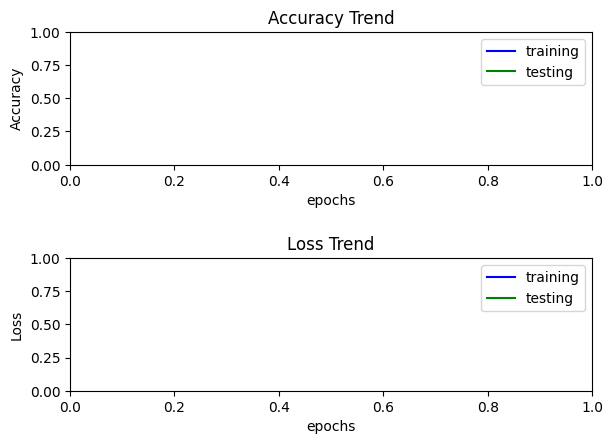

1/1 [==============================] - 0s 229ms/step
y_pred [[0.5992752  0.40072486]
 [0.5954952  0.40450478]
 [0.5949418  0.4050582 ]
 [0.5981032  0.40189674]
 [0.5974322  0.40256777]
 [0.59641856 0.4035814 ]
 [0.59650093 0.40349913]
 [0.5971668  0.40283322]
 [0.59858495 0.40141508]
 [0.59458286 0.4054171 ]
 [0.6023432  0.3976568 ]
 [0.5965329  0.4034671 ]]
y_val [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_pred [0 0 0 0 0 0 0 0 0 0 0 0]
y_val [0 0 0 0 0 0 1 1 1 1 1 1]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.5, 'loss': 0.7131537795066833, 'conf_mat': array([[6, 0],
       [6, 0]]), 'sens (recall)': 0.0, 'f1': 0.0, 'prec': 0.0, 'tn': 6, 'tp': 0, 'fn': 6, 'fp': 0, 'fold': 2}
FOLD :  3
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
stacking all matrices together (12, 224, 224)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Output shape of the model: (None, 2)
48/48 [==============================] - 6s 45ms/step - loss: 1.2386 - accuracy: 0.4792 - val_loss: 0.7073 - val_accuracy: 0.3333


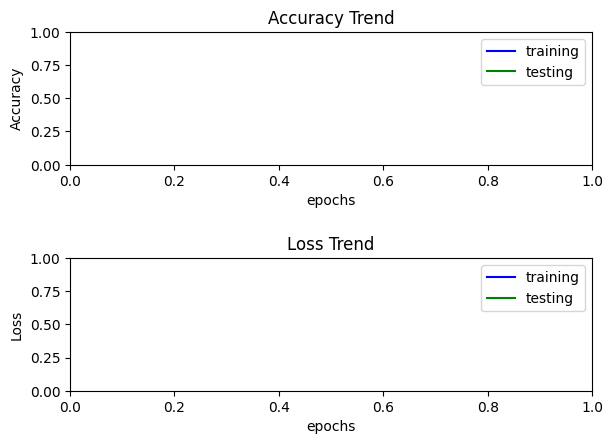

1/1 [==============================] - 0s 151ms/step
y_pred [[0.4815152  0.5184848 ]
 [0.4794515  0.5205485 ]
 [0.4820575  0.5179425 ]
 [0.47927535 0.52072465]
 [0.48241183 0.5175882 ]
 [0.48209494 0.51790506]
 [0.48049238 0.51950765]
 [0.47748584 0.5225142 ]
 [0.48059723 0.51940274]
 [0.48256686 0.51743317]
 [0.4808642  0.5191358 ]
 [0.48144954 0.51855046]]
y_val [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_pred [1 1 1 1 1 1 1 1 1 1 1 1]
y_val [0 0 0 0 0 0 0 0 1 1 1 1]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.3333333432674408, 'loss': 0.7073413729667664, 'conf_mat': array([[0, 8],
       [0, 4]]), 'sens (recall)': 1.0, 'f1': 0.5, 'prec': 0.3333333333333333, 'tn': 0, 'tp': 4, 'fn': 0, 'fp': 8, 'fold': 3}
FOLD :  4
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
stacking all mat

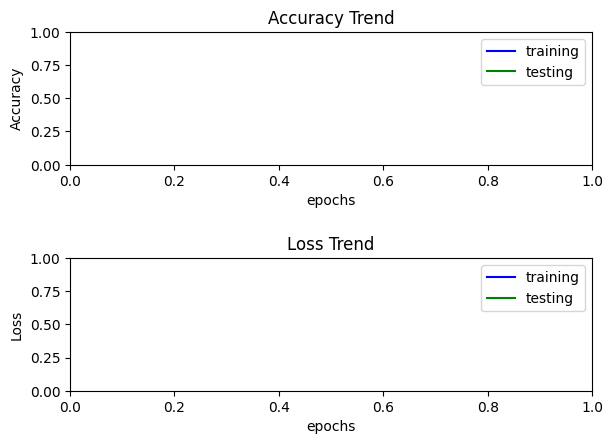

1/1 [==============================] - 0s 142ms/step
y_pred [[0.6914686  0.30853143]
 [0.69685954 0.30314043]
 [0.6911948  0.3088052 ]
 [0.6873746  0.31262538]
 [0.6912434  0.3087566 ]
 [0.68952256 0.31047747]
 [0.68873084 0.31126916]
 [0.6888261  0.31117392]
 [0.6902339  0.30976608]
 [0.69025135 0.30974868]
 [0.6894389  0.31056112]
 [0.68767357 0.3123264 ]]
y_val [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_pred [0 0 0 0 0 0 0 0 0 0 0 0]
y_val [0 0 0 0 0 1 1 1 1 1 1 1]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.4166666567325592, 'loss': 0.8353950381278992, 'conf_mat': array([[5, 0],
       [7, 0]]), 'sens (recall)': 0.0, 'f1': 0.0, 'prec': 0.0, 'tn': 5, 'tp': 0, 'fn': 7, 'fp': 0, 'fold': 4}
FOLD :  5
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
stacking all matrices together 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Output shape of the model: (None, 2)
48/48 [==============================] - 6s 44ms/step - loss: 1.0779 - accuracy: 0.4375 - val_loss: 0.6906 - val_accuracy: 0.5833


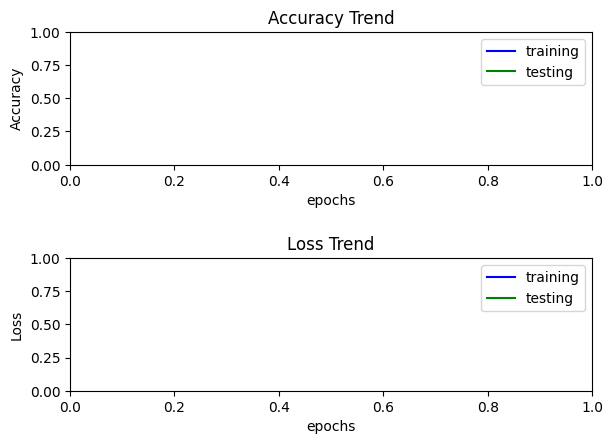

1/1 [==============================] - 0s 137ms/step
y_pred [[0.50813574 0.4918642 ]
 [0.50754845 0.49245152]
 [0.50772905 0.49227092]
 [0.5077567  0.49224332]
 [0.5071896  0.4928104 ]
 [0.50760627 0.49239376]
 [0.5070994  0.4929006 ]
 [0.5074269  0.49257314]
 [0.50745493 0.49254507]
 [0.50790054 0.49209943]
 [0.50703037 0.49296963]
 [0.50723785 0.49276215]]
y_val [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_pred [0 0 0 0 0 0 0 0 0 0 0 0]
y_val [0 0 0 0 0 0 0 1 1 1 1 1]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.5833333134651184, 'loss': 0.6905908584594727, 'conf_mat': array([[7, 0],
       [5, 0]]), 'sens (recall)': 0.0, 'f1': 0.0, 'prec': 0.0, 'tn': 7, 'tp': 0, 'fn': 5, 'fp': 0, 'fold': 5}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      subject                                         psi_matrix  adhd  \
30  subject31  [[1.0, 0.7335304650334341, 0.5727024753524392,...     1   
31  subject32  [[1.0, 0.8849202849245359, 0.47641979712727794...     1   
32  subject33  [[1.0, 0.6810943382864967, 0.44327962331390935...     1   
33  subject34  [[1.0, 0.80614652314455, 0.28590402466996495, ...     1   
34  subject35  [[1.0, 0.8690540665382058, 0.48150904820290213...     1   
..        ...                                                ...   ...   
85  subject86  [[1.0, 0.89889752469231, 0.7009544619594587, 0...     0   
86  subject87  [[1.0, 0.7245683563502671, 0.3846243147163166,...     0   
87  subject88  [[1.0, 0.5069218548942677, 0.2780832849505975,...     0   
88  subject89  [[1.0, 0.8578112374013487, 0.6699982073024148,...     0   
89  subject90  [[1.0, 0.9327588901009396, 0.8204276212582949,...     0   

    autism  healthy  
30       0        0  
31       0        0  
32       0        0  
33       0        0  
3

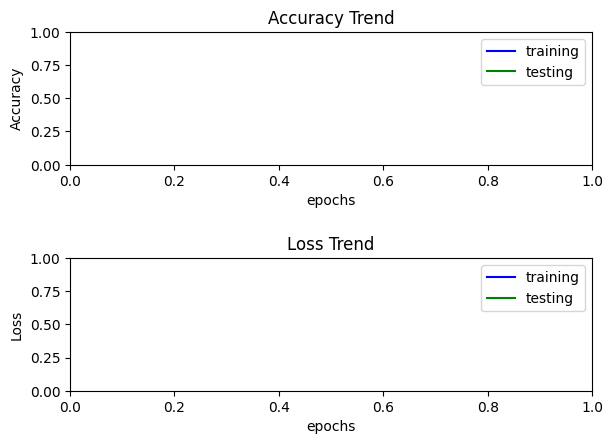

1/1 [==============================] - 0s 135ms/step
y_pred [[0.8388145  0.16118555]
 [0.8397644  0.16023557]
 [0.8423868  0.15761323]
 [0.83904177 0.16095822]
 [0.83981043 0.16018957]
 [0.8394852  0.16051477]
 [0.8387063  0.16129367]
 [0.840249   0.15975101]
 [0.8411817  0.15881832]
 [0.8407733  0.1592267 ]
 [0.8424882  0.1575118 ]
 [0.83847517 0.16152485]]
y_val [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_pred [0 0 0 0 0 0 0 0 0 0 0 0]
y_val [0 0 0 0 1 1 1 1 1 1 1 1]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.3333333432674408, 'loss': 1.2804681062698364, 'conf_mat': array([[4, 0],
       [8, 0]]), 'sens (recall)': 0.0, 'f1': 0.0, 'prec': 0.0, 'tn': 4, 'tp': 0, 'fn': 8, 'fp': 0, 'fold': 1}
FOLD :  2
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
stacking all matrices together 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Output shape of the model: (None, 2)
48/48 [==============================] - 6s 48ms/step - loss: 0.9703 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.5000


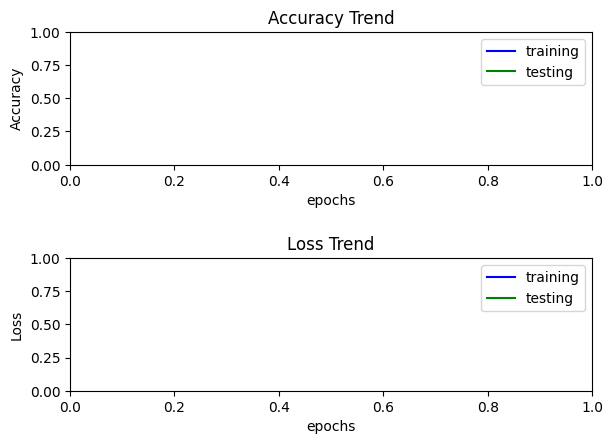

1/1 [==============================] - 0s 137ms/step
y_pred [[0.48172832 0.5182717 ]
 [0.48167232 0.5183277 ]
 [0.48166728 0.51833266]
 [0.48168996 0.51831   ]
 [0.48169917 0.51830083]
 [0.4816708  0.5183292 ]
 [0.4817179  0.51828206]
 [0.48172262 0.51827735]
 [0.48177186 0.5182281 ]
 [0.48156068 0.5184393 ]
 [0.48164114 0.5183588 ]
 [0.48169893 0.51830107]]
y_val [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_pred [1 1 1 1 1 1 1 1 1 1 1 1]
y_val [0 0 0 0 0 0 1 1 1 1 1 1]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.5, 'loss': 0.6938158869743347, 'conf_mat': array([[0, 6],
       [0, 6]]), 'sens (recall)': 1.0, 'f1': 0.6666666666666666, 'prec': 0.5, 'tn': 0, 'tp': 6, 'fn': 0, 'fp': 6, 'fold': 2}
FOLD :  3
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
stacking all matrices together 

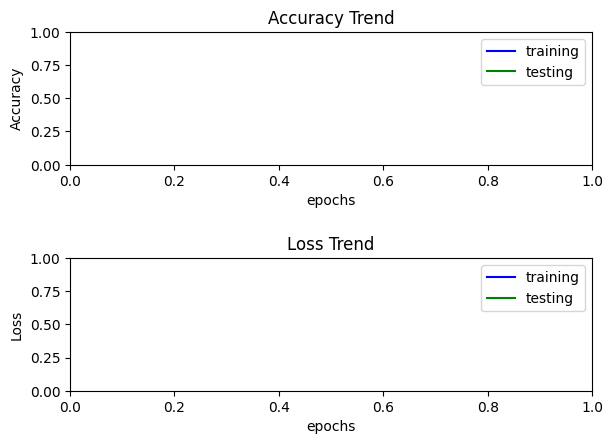

1/1 [==============================] - 0s 138ms/step
y_pred [[0.4305977  0.56940234]
 [0.4386232  0.5613768 ]
 [0.4309371  0.5690629 ]
 [0.42855465 0.57144535]
 [0.43080837 0.5691916 ]
 [0.43064553 0.5693545 ]
 [0.43089607 0.56910396]
 [0.43061644 0.56938356]
 [0.43498757 0.5650124 ]
 [0.43413073 0.5658693 ]
 [0.4312399  0.56876004]
 [0.43033856 0.56966144]]
y_val [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_pred [1 1 1 1 1 1 1 1 1 1 1 1]
y_val [0 0 0 0 0 0 0 0 1 1 1 1]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.3333333432674408, 'loss': 0.7493435740470886, 'conf_mat': array([[0, 8],
       [0, 4]]), 'sens (recall)': 1.0, 'f1': 0.5, 'prec': 0.3333333333333333, 'tn': 0, 'tp': 4, 'fn': 0, 'fp': 8, 'fold': 3}
FOLD :  4
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
stacking all mat

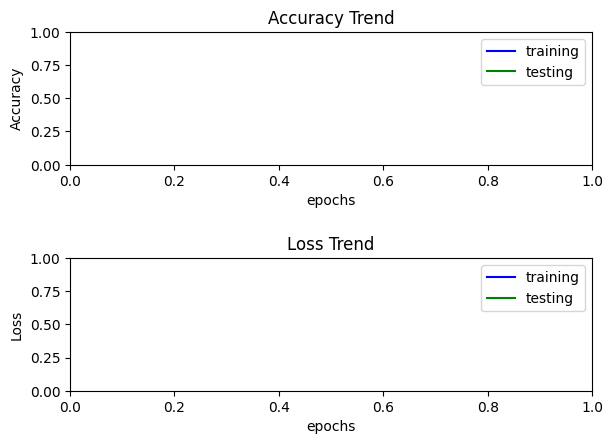

1/1 [==============================] - 0s 140ms/step
y_pred [[0.22145948 0.7785405 ]
 [0.22108212 0.7789179 ]
 [0.21953522 0.78046477]
 [0.22325855 0.77674145]
 [0.22283201 0.777168  ]
 [0.22179186 0.7782082 ]
 [0.22285374 0.7771462 ]
 [0.21915756 0.7808424 ]
 [0.22075962 0.7792404 ]
 [0.22256382 0.7774362 ]
 [0.22645319 0.7735468 ]
 [0.2206821  0.779318  ]]
y_val [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_pred [1 1 1 1 1 1 1 1 1 1 1 1]
y_val [0 0 0 0 0 1 1 1 1 1 1 1]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.5833333134651184, 'loss': 0.7742754817008972, 'conf_mat': array([[0, 5],
       [0, 7]]), 'sens (recall)': 1.0, 'f1': 0.7368421052631579, 'prec': 0.5833333333333334, 'tn': 0, 'tp': 7, 'fn': 0, 'fp': 5, 'fold': 4}
FOLD :  5
stacking all matrices together (48, 224, 224)
adding channel dimension (48, 224, 224, 1)
increasing channels for vgg (48, 224, 224, 3)
s

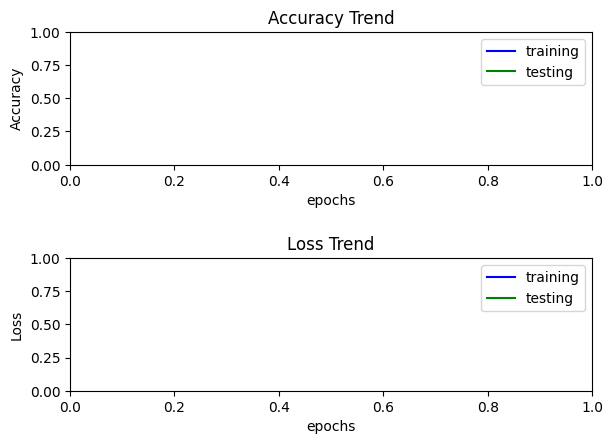

1/1 [==============================] - 0s 162ms/step
y_pred [[0.7428887  0.2571113 ]
 [0.7292238  0.27077624]
 [0.71733177 0.2826682 ]
 [0.728567   0.27143303]
 [0.7081351  0.2918648 ]
 [0.73320085 0.26679915]
 [0.7242618  0.27573818]
 [0.72318107 0.27681893]
 [0.7270443  0.27295566]
 [0.7123452  0.2876548 ]
 [0.71012    0.28988004]
 [0.71423876 0.28576124]]
y_val [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_pred [0 0 0 0 0 0 0 0 0 0 0 0]
y_val [0 0 0 0 0 0 0 1 1 1 1 1]
Type of y_pred using model.predict: <class 'numpy.ndarray'>
shape of the y_pred using model.predict: (12,)
Scores {'acc': 0.5833333134651184, 'loss': 0.7133044600486755, 'conf_mat': array([[7, 0],
       [5, 0]]), 'sens (recall)': 0.0, 'f1': 0.0, 'prec': 0.0, 'tn': 7, 'tp': 0, 'fn': 5, 'fp': 0, 'fold': 5}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      subject                                         psi_matrix  adhd  \
0    subject1  [[1.0, 0.9121749319470445, 0.5998911447858901,...     0   
1    subject2  [[1.0, 0.737845980508526, 0.6564429476312834, ...     0   
2    subject3  [[1.0, 0.7745085228540051, 0.6128628356660338,...     0   
3    subject4  [[1.0, 0.9101208647908265, 0.5761238195504282,...     0   
4    subject5  [[1.0, 0.8178086643416217, 0.5200617901160923,...     0   
..        ...                                                ...   ...   
85  subject86  [[1.0, 0.89889752469231, 0.7009544619594587, 0...     0   
86  subject87  [[1.0, 0.7245683563502671, 0.3846243147163166,...     0   
87  subject88  [[1.0, 0.5069218548942677, 0.2780832849505975,...     0   
88  subject89  [[1.0, 0.8578112374013487, 0.6699982073024148,...     0   
89  subject90  [[1.0, 0.9327588901009396, 0.8204276212582949,...     0   

    autism  healthy  
0        1        0  
1        1        0  
2        1        0  
3        1        0  
4

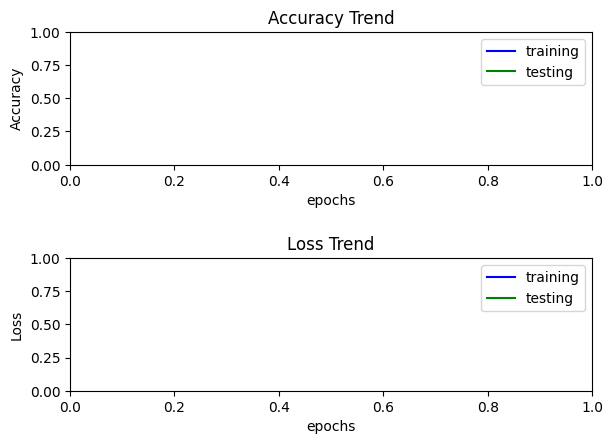

1/1 [==============================] - 0s 139ms/step
y_pred [[0.31665578 0.34758258 0.33576164]
 [0.31645313 0.34718147 0.33636543]
 [0.3169663  0.34672198 0.33631176]
 [0.31637982 0.3479209  0.3356993 ]
 [0.3165674  0.3468665  0.3365661 ]
 [0.31794804 0.34491366 0.33713832]
 [0.3176483  0.34692806 0.33542365]
 [0.31630257 0.3461304  0.33756706]
 [0.31705093 0.34725532 0.33569372]
 [0.3170793  0.34688684 0.33603382]
 [0.31711313 0.34556583 0.33732104]
 [0.31696975 0.34617808 0.33685216]
 [0.31666264 0.34691802 0.33641928]
 [0.3169107  0.34800732 0.33508193]
 [0.3164742  0.34849027 0.33503556]
 [0.3162126  0.34623545 0.3375519 ]
 [0.31746805 0.34669596 0.33583602]
 [0.31727237 0.34617108 0.33655655]]
y_val [[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
y_pred [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
y_val [1 1 1 1 1 1 1 1 0 0 0 0 0 0 2 2 2 2]
Type of y_pred using model.predic

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Output shape of the model: (None, 3)
72/72 [==============================] - 7s 42ms/step - loss: 1.2841 - accuracy: 0.2917 - val_loss: 1.0862 - val_accuracy: 0.4444


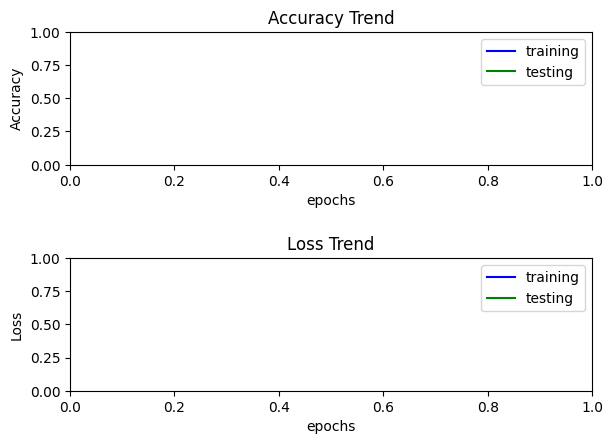

1/1 [==============================] - 0s 166ms/step
y_pred [[0.319411   0.31496257 0.36562636]
 [0.3177326  0.31743354 0.36483386]
 [0.3187051  0.31712422 0.36417064]
 [0.32019144 0.3142211  0.36558744]
 [0.31645137 0.31711966 0.36642894]
 [0.31913266 0.31659764 0.36426976]
 [0.31732723 0.31674898 0.3659238 ]
 [0.31759167 0.3124009  0.3700074 ]
 [0.31922296 0.31640184 0.3643752 ]
 [0.31930146 0.31379524 0.36690328]
 [0.31881842 0.31629825 0.36488333]
 [0.31898963 0.31785813 0.36315227]
 [0.31895965 0.31679183 0.36424854]
 [0.31782904 0.31744528 0.36472565]
 [0.3169367  0.31768894 0.36537433]
 [0.31892502 0.3179026  0.3631724 ]
 [0.3158775  0.31719422 0.3669283 ]
 [0.31823224 0.31742683 0.36434096]]
y_val [[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
y_pred [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
y_val [1 1 1 1 0 0 0 0 0 0 2 2 2 2 2 2 2 2]
Type of y_pred using model.predic

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Output shape of the model: (None, 3)
72/72 [==============================] - 8s 44ms/step - loss: 1.3764 - accuracy: 0.2778 - val_loss: 1.1705 - val_accuracy: 0.2222


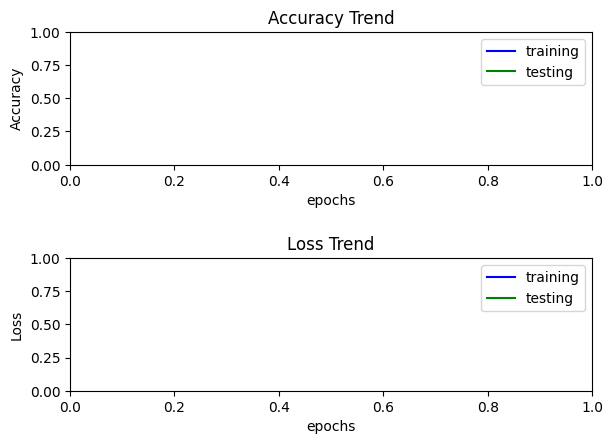

1/1 [==============================] - 0s 222ms/step
y_pred [[0.33373785 0.27490494 0.39135724]
 [0.334261   0.27455682 0.39118218]
 [0.33409506 0.27481222 0.39109275]
 [0.33428124 0.2743593  0.39135945]
 [0.33415762 0.27443826 0.39140406]
 [0.3341365  0.27434877 0.39151475]
 [0.3342192  0.27463162 0.39114922]
 [0.33414567 0.27455124 0.3913031 ]
 [0.33413297 0.27465817 0.39120886]
 [0.3343571  0.2741937  0.39144915]
 [0.33401677 0.2746824  0.39130083]
 [0.3340048  0.2748618  0.3911334 ]
 [0.33372486 0.27532902 0.39094612]
 [0.33381292 0.27529064 0.39089638]
 [0.3342367  0.27451864 0.39124462]
 [0.33388254 0.27548143 0.390636  ]
 [0.33388117 0.27519172 0.39092708]
 [0.3341509  0.2742309  0.39161816]]
y_val [[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
y_pred [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
y_val [1 1 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2]
Type of y_pred using model.predic

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Output shape of the model: (None, 3)
72/72 [==============================] - 8s 42ms/step - loss: 1.2979 - accuracy: 0.4028 - val_loss: 1.2078 - val_accuracy: 0.0556


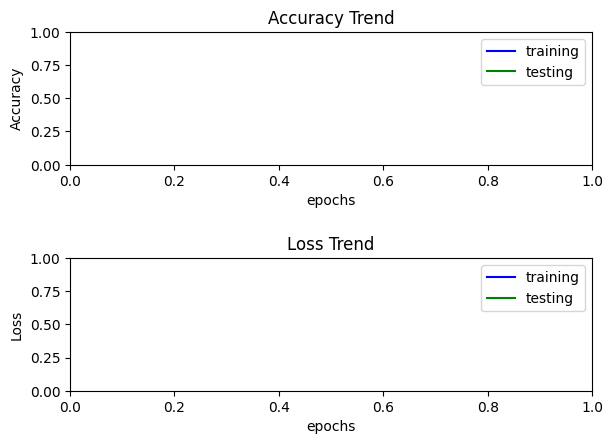

1/1 [==============================] - 0s 139ms/step
y_pred [[0.29090485 0.41200897 0.29708615]
 [0.28898218 0.41376483 0.29725298]
 [0.2927495  0.40848115 0.29876935]
 [0.28461108 0.41742858 0.2979603 ]
 [0.29230872 0.41035506 0.2973362 ]
 [0.29059172 0.4095976  0.29981065]
 [0.29329315 0.41004413 0.29666275]
 [0.2848882  0.41517544 0.29993635]
 [0.29404196 0.40862298 0.2973351 ]
 [0.29096547 0.41146502 0.29756948]
 [0.29099384 0.41131407 0.29769212]
 [0.2902241  0.41220668 0.29756922]
 [0.29027522 0.41314852 0.29657626]
 [0.29324707 0.4081614  0.2985915 ]
 [0.2940034  0.4073423  0.2986543 ]
 [0.29411596 0.408225   0.297659  ]
 [0.29128808 0.41128796 0.297424  ]
 [0.28954935 0.41432047 0.29613018]]
y_val [[0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
y_pred [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
y_val [1 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
Type of y_pred using model.predic

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Output shape of the model: (None, 3)
72/72 [==============================] - 7s 46ms/step - loss: 1.3022 - accuracy: 0.3611 - val_loss: 1.0883 - val_accuracy: 0.3889


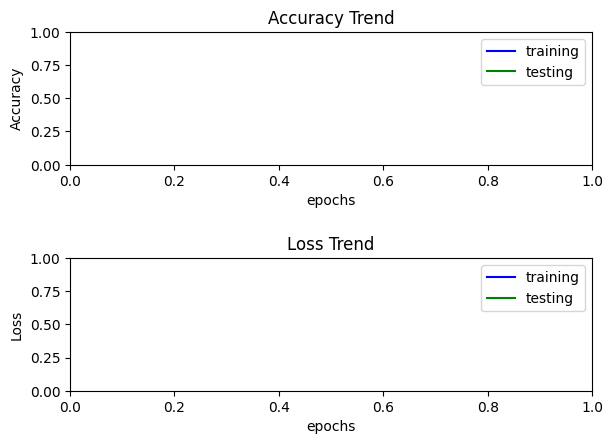

1/1 [==============================] - 0s 136ms/step
y_pred [[0.28510872 0.414778   0.3001132 ]
 [0.2885189  0.40934736 0.30213377]
 [0.2861238  0.41459867 0.29927748]
 [0.28473496 0.41315475 0.30211025]
 [0.28737196 0.4101185  0.30250958]
 [0.28545812 0.416403   0.29813886]
 [0.28573945 0.4147369  0.29952365]
 [0.2875571  0.41740543 0.29503748]
 [0.28683427 0.41128883 0.30187687]
 [0.28609926 0.4156129  0.29828784]
 [0.28626263 0.41283628 0.30090111]
 [0.2860959  0.41335297 0.30055115]
 [0.28759798 0.4140022  0.29839987]
 [0.28633443 0.4142633  0.29940224]
 [0.2869589  0.41174352 0.30129755]
 [0.28924385 0.40727317 0.30348295]
 [0.28700745 0.41125908 0.3017335 ]
 [0.28728944 0.4109895  0.30172104]]
y_val [[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
y_pred [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
y_val [1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2]
Type of y_pred using model.predic

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [17]:
# Define a list of choices
choices = ['A', 'B', 'C', 'D']

# Create an empty dictionary to store the result dataframes
result_dfs = {}

# Loop through each choice
for choice in choices:
    # Call the driver() function with the current choice
    result_df = driver(choice)

    # Store the result dataframe in the dictionary with the choice as the key
    result_dfs[choice] = result_df

In [18]:
print(result_dfs['A'])

  fold       acc      loss          conf_mat  sens (recall)        f1  \
0    1  0.666667  0.685836  [[8, 0], [4, 0]]            0.0  0.000000   
1    2  0.500000  0.693253  [[0, 6], [0, 6]]            1.0  0.666667   
2    3  0.333333  1.701956  [[4, 0], [8, 0]]            0.0  0.000000   
3    4  0.416667  0.725062  [[0, 7], [0, 5]]            1.0  0.588235   
4    5  0.416667  0.853096  [[5, 0], [7, 0]]            0.0  0.000000   

       prec tn tp fn fp  
0  0.000000  8  0  4  0  
1  0.500000  0  6  0  6  
2  0.000000  4  0  8  0  
3  0.416667  0  5  0  7  
4  0.000000  5  0  7  0  


In [19]:
print(result_dfs['B'])

  fold       acc      loss          conf_mat  sens (recall)   f1      prec tn  \
0    1  0.666667  0.678194  [[0, 4], [0, 8]]            1.0  0.8  0.666667  0   
1    2  0.500000  0.713154  [[6, 0], [6, 0]]            0.0  0.0  0.000000  6   
2    3  0.333333  0.707341  [[0, 8], [0, 4]]            1.0  0.5  0.333333  0   
3    4  0.416667  0.835395  [[5, 0], [7, 0]]            0.0  0.0  0.000000  5   
4    5  0.583333  0.690591  [[7, 0], [5, 0]]            0.0  0.0  0.000000  7   

  tp fn fp  
0  8  0  4  
1  0  6  0  
2  4  0  8  
3  0  7  0  
4  0  5  0  


In [20]:
print(result_dfs['C'])

  fold       acc      loss          conf_mat  sens (recall)        f1  \
0    1  0.333333  1.280468  [[4, 0], [8, 0]]            0.0  0.000000   
1    2  0.500000  0.693816  [[0, 6], [0, 6]]            1.0  0.666667   
2    3  0.333333  0.749344  [[0, 8], [0, 4]]            1.0  0.500000   
3    4  0.583333  0.774275  [[0, 5], [0, 7]]            1.0  0.736842   
4    5  0.583333  0.713304  [[7, 0], [5, 0]]            0.0  0.000000   

       prec tn tp fn fp  
0  0.000000  4  0  8  0  
1  0.500000  0  6  0  6  
2  0.333333  0  4  0  8  
3  0.583333  0  7  0  5  
4  0.000000  7  0  5  0  


In [21]:
print(result_dfs['D'])

  fold       acc      loss                            conf_mat  sens (recall)  \
0    1  0.444444  1.095889   [[0, 6, 0], [0, 8, 0], [0, 4, 0]]       0.333333   
1    2  0.444444  1.086197   [[0, 0, 6], [0, 0, 4], [0, 0, 8]]       0.333333   
2    3  0.222222  1.170515  [[0, 0, 4], [0, 0, 10], [0, 0, 4]]       0.333333   
3    4  0.055556  1.207794  [[0, 10, 0], [0, 1, 0], [0, 7, 0]]       0.333333   
4    5  0.388889  1.088251   [[0, 4, 0], [0, 7, 0], [0, 7, 0]]       0.333333   

         f1      prec  
0  0.205128  0.148148  
1  0.205128  0.148148  
2  0.121212  0.074074  
3  0.035088  0.018519  
4  0.186667  0.129630  


# Binary Classification


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def make_dataset(choice):
    # Load dataframe from the pickle file
    data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/RRC_FcMaps/FCmaps_data(132x132).pkl')

    if choice == 'A':
        # Filter rows where 'adhd' or 'autism' is 1 (keep only ADHD or autism subjects)
        data = data[(data['adhd'] == 1) | (data['autism'] == 1)]
        y_cols = ['adhd', 'autism']  # Specify the columns for y
    elif choice == 'B':
        # Filter rows where 'autism' or 'healthy' is 1 (keep only autism or healthy subjects)
        data = data[(data['autism'] == 1) | (data['healthy'] == 1)]
        y_cols = ['autism', 'healthy']  # Specify the columns for y
    elif choice == 'C':
        # Filter rows where 'adhd' or 'healthy' is 1 (keep only ADHD or healthy subjects)
        data = data[(data['adhd'] == 1) | (data['healthy'] == 1)]
        y_cols = ['adhd', 'healthy']  # Specify the columns for y
    elif choice == 'D':
        # Keep all rows
        y_cols = ['adhd', 'autism', 'healthy']  # Specify the columns for y
    else:
        print("Invalid choice. Please enter 'A', 'B', 'C', or 'D'.")
        return pd.DataFrame(), []

    print(data)
    return data, y_cols

In [ ]:
def driver():

    choice = input("Enter your choice (A, B, C, or D): ").upper()

    df, y_cols = make_dataset(choice)
    #print(d.head)

    X = df['fcmap'].values
    # print(X.shape)
    # print(X)
    print(type(X))
    y = df[y_cols].values
    #y = to_categorical(y, num_classes=3)
    # print(y.shape)
    # print(y)
    print(type(y))

    return df, y

In [ ]:
data, cols = driver()

In [ ]:
data

In [ ]:
data.shape

In [ ]:
cols

In [ ]:
cols.shape

In [ ]:
d1 = data.iloc[1,1]

In [ ]:
d1

In [ ]:
d1.shape

# 3 class confusion matrix

In [ ]:
from sklearn import metrics
import pandas as pd

In [ ]:
d = "dogs"
c = "cats"
f = "fish"

In [ ]:
y_true = [0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1,1, 2,2,2,2,2,2,2,2,2]

y_pred = [0,0,0,0,1,2,1, 0,0,0,0,0,0,0,2,2,1, 0,0,0,1,1,1,1,1,2]

In [ ]:
print(metrics.confusion_matrix(y_true, y_pred))

In [ ]:
print(metrics.classification_report(y_true, y_pred, digits = 3))

In [ ]:
report = metrics.classification_report(y_true, y_pred, output_dict=True)

In [ ]:
report_df = pd.DataFrame(report).T

In [ ]:
report_df

In [ ]:
# Select the first three rows
report_df_top3 = report_df.head(3)

# Calculate average metrics for the first three rows
avg_precision = report_df_top3['precision'].mean()
avg_recall = report_df_top3['recall'].mean()
avg_f1_score = report_df_top3['f1-score'].mean()

print(f"Average Precision (first 3 classes): {avg_precision:.3f}")
print(f"Average Recall (first 3 classes): {avg_recall:.3f}")
print(f"Average F1-Score (first 3 classes): {avg_f1_score:.3f}")